# cells
---
Script to perform electron identification using cell-level information. Two separate approaches are tested: Convolutional- and graph neural networks.

---
## Initialisation

In [1]:
%matplotlib notebook

# Basic import(s)
import h5py
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# ML import(s)
import hep_ml

# Pytorch import(s)
import torch
from torch.autograd import Variable
import torch.nn.functional as F
CUDA = torch.cuda.is_available()

# Project import(s)
from convert import *

[WARN] ROOT and/or root_numpy are not installed. This might lead to problems.


Using TensorFlow backend.


Load data from HDF5 file

In [2]:
with h5py.File('data/data_00000000.h5', 'r') as hf:
    data = hf['egamma'][:]
    pass

In [3]:
variables = list(data.dtype.names)

print "Read {} events.".format(data.shape[0])
print "Variables:"
for var in variables:
    print "  {}".format(var)
    pass


Read 100000 events.
Variables:
  truth_pt
  truth_et
  truth_eta
  truth_phi
  truth_type
  truth_origin
  truth_PdgId
  cells_energy
  cells_gain
  cells_provenance
  cells_sampling
  cells_time
  cells_x
  cells_y
  cells_z
  cells_eta
  cells_phi
  signal


Filter out corrupted samples

In [4]:
bad = np.zeros((data.shape[0],)).astype(bool)
for var in variables:
    if   var.startswith('truth_'):  # Scalar
        bad |= np.isnan(data[var]) | np.isinf(data[var])
    elif var.startswith('cells_'):  # Vector
        for idx in range(data.shape[0]):
            bad[idx] |= np.any(np.isnan(data[var][idx])) | np.any(np.isinf(data[var][idx]))
            pass
    else:
        print "[WARN]  Variable {} not recognised.".format(var)
        pass
    pass

print "Found {} corrupted/bad events.".format(np.sum(bad))
data = data[~bad]

[WARN]  Variable signal not recognised.
Found 14680 corrupted/bad events.


Reweighting to flat $p_{T}$ spectrum

In [5]:
from hep_ml.reweight import GBReweighter

# Only reweight once
try:
    _reweighted
except NameError:

    # Get signal mask
    msk = data['signal'] == 1
    var = 'truth_pt'

    # Get _reasonable_ variable extrema, discarding at least bottom- and top 2% for each class.
    xmin = max(np.percentile(data[var][ msk],  2), np.percentile(data[var][~msk],  2))
    xmax = min(np.percentile(data[var][ msk], 98), np.percentile(data[var][~msk], 98))

    # Discard data outside this region
    good = (data[var] >= xmin) & (data[var] <= xmax)
    data = data[good]
    msk  = data['signal'] == 1
    print "Discarding {} events with {} outside [{}, {}]".format(np.sum(~good), var, xmin, xmax)

    # Create signal- and background array for variable(s) for which to reweight to flatness
    sig = np.array(data[var][ msk])
    bkg = np.array(data[var][~msk])

    # Get target array
    target = np.random.rand(data.size) * (xmax - xmin) + xmin

    # Create GBReweighter instances
    opts = dict(max_depth=5, n_estimators=200)  #, gb_args={'subsample': 0.5})
    reweighter_sig = GBReweighter(**opts)
    reweighter_bkg = GBReweighter(**opts)

    # Reweight signal and background to match target
    reweighter_sig.fit(original=sig, target=target)
    reweighter_bkg.fit(original=bkg, target=target)

    # Compute signal and background weights
    weight_sig = reweighter_sig.predict_weights(sig)
    weight_bkg = reweighter_bkg.predict_weights(bkg)

    # Rescale weights to have sum(w_sig) = N/2, sum(w_bkg) = N/2 --> sum(w) = N
    weight_sig *= data.size / 2. / np.sum(weight_sig)
    weight_bkg *= data.size / 2. / np.sum(weight_bkg)

    # Combine weights to single array
    weight = np.zeros((data.shape[0],))
    weight[ msk] = weight_sig
    weight[~msk] = weight_bkg

    # Add field to data array
    from numpy.lib.recfunctions import append_fields
    #data = append_fields(data, 'weight', weight)  # @FIXME
    
    # Set flag
    _reweighted = True
    pass

/Users/asogaard/Library/Python/2.7/lib/python/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Discarding 17523 events with truth_pt outside [1690.82, 13176.0]


Study simple distributions

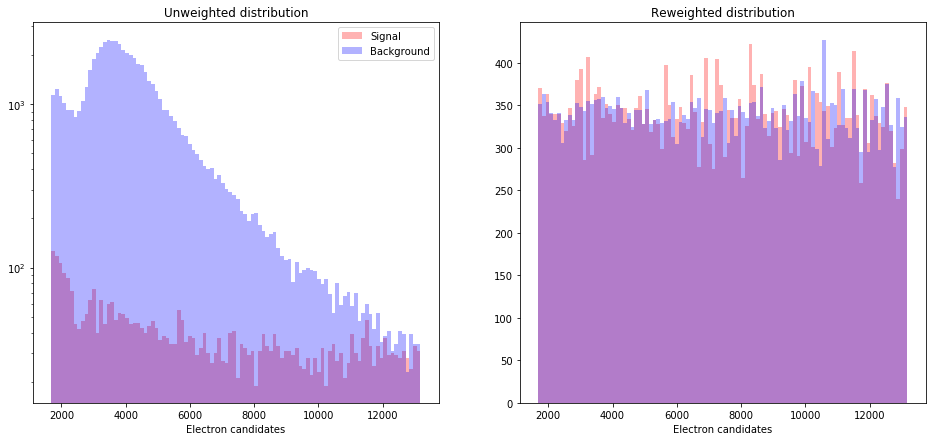

In [6]:
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(16,7))
bins = np.linspace(xmin, xmax, 100 + 1, endpoint=True)
msk = data['signal'] == 1

ax[0].set_title("Unweighted distribution")
ax[0].hist(data['truth_pt'][ msk].tolist(), bins=bins, alpha=0.3, color='red',  label='Signal')
ax[0].hist(data['truth_pt'][~msk].tolist(), bins=bins, alpha=0.3, color='blue', label='Background')
ax[0].set_yscale('log', nonposy='clip')
ax[0].set_xlabel(r"Truth $p_{T}$ [MeV]")
ax[0].set_xlabel(r"Electron candidates")

ax[1].set_title("Reweighted distribution")
#ax[1].hist(data['truth_pt'][ msk].tolist(), bins=bins, weights=data['weight'][ msk], alpha=0.3, color='red')
#ax[1].hist(data['truth_pt'][~msk].tolist(), bins=bins, weights=data['weight'][~msk], alpha=0.3, color='blue')
ax[1].hist(data['truth_pt'][ msk].tolist(), bins=bins, weights=weight[ msk], alpha=0.3, color='red')
ax[1].hist(data['truth_pt'][~msk].tolist(), bins=bins, weights=weight[~msk], alpha=0.3, color='blue')

ax[1].set_xlabel(r"Truth $p_{T}$ [MeV]")
ax[1].set_xlabel(r"Electron candidates")

ax[0].legend()
plt.show()

Prepare training inputs and -labels arrays.

In [7]:
# Determine network training features
excl = ['cells_gain', 'cells_gain', 'cells_time', 'cells_provenance', 'cells_sampling']
features = list(filter(lambda name: name.startswith('cells_') and name not in excl, data.dtype.names))
print "Features:", features

# Prepare arrays
inputs = data[features]  .copy()
labels = data[['signal']].copy()
#weight = data[['weight']].copy()  @FIXME

# Compute feature averages and standard deviations
M = np.array(inputs.tolist())
m_avg = np.zeros(M.shape)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        m_avg[i][j] = np.mean(M[i][j])
        pass
    pass

feat_mean = np.mean(m_avg, axis=0)
feat_std  = np.std (m_avg, axis=0)

# Print feature information
for idx, feat in enumerate(features):
    print "  {:<16s}: {:-9.3f} ± {:-9.3f}".format(feat, feat_mean[idx], feat_std[idx])
    pass

#### # Automatic feature standardisation
#### for idx, feat in enumerate(features):
####     inputs[feat] -= feat_mean[idx]
####     inputs[feat] /= feat_std [idx]
####     pass

# Manually standardise features
inputs['cells_energy']     /= 1000.  # MeV -> GeV (?)
#inputs['cells_provenance'] /= 1000.
inputs['cells_x']          /= 1000.  # mm -> m
inputs['cells_y']          /= 1000.  # mm -> m
inputs['cells_z']          /= 1000.  # mm -> m

Features: ['cells_energy', 'cells_x', 'cells_y', 'cells_z', 'cells_eta', 'cells_phi']
  cells_energy    :    70.229 ±   120.731
  cells_x         :    -1.593 ±  1077.930
  cells_y         :     7.963 ±  1086.902
  cells_z         :     7.098 ±  2473.663
  cells_eta       :     0.002 ±     1.258
  cells_phi       :     0.012 ±     1.755


---
## Visualisation

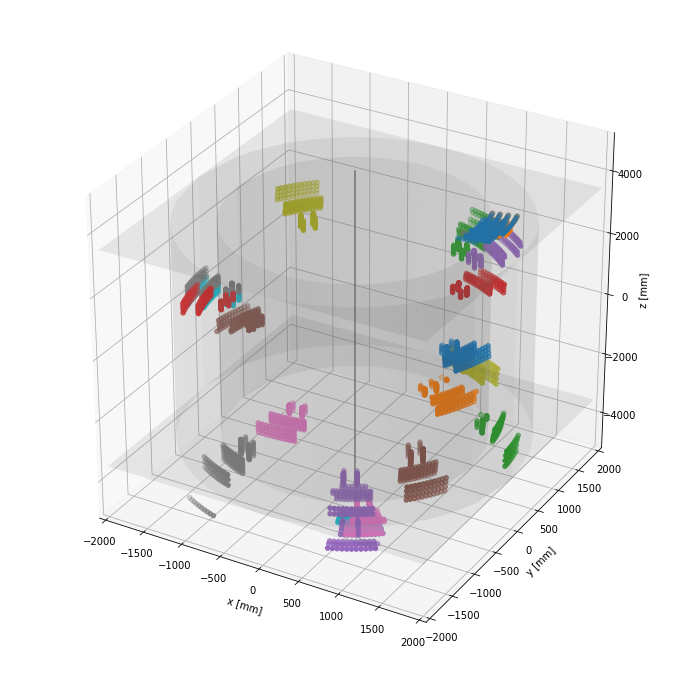

In [8]:
from mpl_toolkits.mplot3d import Axes3D

num_candidates = data.shape[0]

# Create figure
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

# Plot cells
for icand in range(20):
    x = data['cells_x'][icand]
    y = data['cells_y'][icand]
    z = data['cells_z'][icand]

    ax.scatter(x, y, z)  #, alpha=0.2)
    pass

# Draw end-cap dividers
x_ = np.linspace(-2000, 2000, 40 + 1, endpoint=True)
y_ = np.linspace(-2000, 2000, 40 + 1, endpoint=True)
X_, Y_ = np.meshgrid(x_, y_)
Z_ = np.ones_like(X_) * 3500
ax.plot_surface(X_, Y_, +Z_, color='gray', alpha=0.1)
ax.plot_surface(X_, Y_, -Z_, color='gray', alpha=0.1)

# Draw beam-line
z_ = np.linspace(-5000, 5000, 40 + 1, endpoint=True)
ax.plot(x_ * 0, y_ * 0, z_, color='gray')

# Plot simplistic detector
bins = 40
# -- ECAL barrel inner
r = 1500
x_ = np.linspace(-r, r, bins + 1)
z_ = np.linspace(-3500, 3500, bins + 1)
X_, Z_ = np.meshgrid(x_, z_)
Y_ = np.sqrt(r**2 - X_**2)
ax.plot_surface(X_, +Y_, Z_, color='gray', alpha=0.1)
ax.plot_surface(X_, -Y_, Z_, color='gray', alpha=0.1)

# -- ECAL barrel outer
r = 2000
x_ = np.linspace(-r, r, bins + 1)
z_ = np.linspace(-3500, 3500, bins + 1)
X_, Z_ = np.meshgrid(x_, z_)
Y_ = np.sqrt(r**2 - X_**2)
ax.plot_surface(X_, +Y_, Z_, color='gray', alpha=0.1)
ax.plot_surface(X_, -Y_, Z_, color='gray', alpha=0.1)

# Decorations
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')
ax.set_xlim(-2000,2000)
ax.set_ylim(-2000,2000)
ax.set_zlim(-5000,5000)

# Show
plt.show()

---
## GNN

Create sample generator.

In [9]:
dtype = torch.FloatTensor
def generator_ (inputs, labels, weight):
    """
    Generate properly formatted training examples and -labels.
    
    Yields:
        h, y, w: Tuple of training example inputs, label, and weight.
    """
    for idx in range(inputs.shape[0]):
        
        # Numpy arrays
        h_ = np.array(inputs[idx].tolist(), dtype=np.float).T
        y_ = labels[idx].astype(np.float).reshape(-1,)
        w_ = weight[idx].astype(np.float).reshape(-1,)

        # Pytorch tensors
        h_ = torch.from_numpy(h_).type(dtype)
        y_ = torch.from_numpy(y_).type(dtype)
        w_ = torch.from_numpy(w_).type(dtype)
        
        # Put on GPU
        if CUDA:
            h_, y_, w_ = h_.cuda(), y_.cuda(), w_.cuda()
            pass
        
        yield h_, y_, w_

generator = generator_(inputs, labels, weight)

Define grid operators, inducing adjacency measures.

In [10]:
# Fuzz-factor to avoid divergences
eps = np.finfo(float).eps

# Fixed column indices
ie   = features.index('cells_energy')
ix   = features.index('cells_x')
iy   = features.index('cells_y')
iz   = features.index('cells_z')
iphi = features.index('cells_phi')
ieta = features.index('cells_eta')

# Row-softmax decorator
def _row_softmax (operator):
    """
    Function decorator, ensuring that the matrix output of some operator is row-
    normalised by softmax, in order to resemble a transition probability matrix.
    
    Arguments:
        M: Arbitrary 2D matrix.
        
    Returns:
        Row-softmaxed version of M.
    """
    def wrapper (*args, **kwargs):
        M = operator(*args, **kwargs)
        return torch.exp(M) / torch.sum(torch.exp(M), dim=1).view(M.shape[0],1).expand(*M.shape)
    return wrapper


# Stop-gradient decorator
def _stop_gradient (fn):
    """
    ...
    
    Arguments:
        ...
        
    Returns:
        ...
    """
    def wrapper (*args, **kwargs):
        V = fn(*args, **kwargs)
        return Variable(V.data, requires_grad=False)
    return wrapper


# Symmetrise decorator
def _symmetrise (operator):
    """
    Function decorator, symmetrising  the matrix output of some operator.
    
    Arguments:
        M: Arbitrary 2D matrix.
        
    Returns:
        Symmetrised version of M.
    """
    def wrapper (*args, **kwargs):
        M = operator(*args, **kwargs)
        return 0.5 * (M + M.transpose(0,1))
    return wrapper


# Identity matrix
def identity_matrix (h):
    """
    Compute identity matrix for sample `h`.
    
    Arguments:
        h: Input matrix with shape (num_vertices, num_features).
        
    Returns:
        Identity matrix with shape (num_vertices, num_vertices).
    """
    # Number of vertices
    N = h.shape[0]
    return Variable(torch.eye(N,N), requires_grad=False)


# Adjacency matrices
@_stop_gradient
@_row_softmax 
def euclidean_adjacency_matrix (h):
    """
    Compute fixed Euclidean-distance adjacency matrix for sample `h`.

    Arguments:
        h: Input matrix with shape (num_vertices, num_features).
        
    Returns:
        Euclidean-distance adjancency matrix with shape (num_vertices, 
            num_vertices), row-softmaxed.
    """
    # Number of vertices
    N = h.shape[0]
    
    # Vertex coordinates
    x = h[:,ix]
    y = h[:,iy]
    z = h[:,iz]

    # Grid coordinates
    X = x.expand(N,N)
    Y = y.expand(N,N)
    Z = z.expand(N,N)

    # Pair-wise coordinate differences
    dX = X - X.transpose(0,1)
    dY = Y - Y.transpose(0,1)
    dZ = Z - Z.transpose(0,1)

    # Minus Euclidean distance (large values -> adjacent)
    # @TODO: 
    #  - Take time into account? Causal distance?
    return - torch.sqrt(torch.pow(dX, 2.) + torch.pow(dY, 2.) + torch.pow(dZ, 2.))


@_stop_gradient
@_row_softmax  # @_row_normalise
def dR_adjacency_matrix (h):
    """
    Compute fixed dR-distance adjacency matrix for sample `h`.
    
    Arguments:
        h: Input matrix with shape (num_vertices, num_features).
        
    Returns:
        Detector-dR-distance adjancency matrix with shape (num_vertices, 
            num_vertices), row-softmaxed.
    """
    pi    = np.pi
    twopi = 2. * pi
    
    # Number of vertices
    N = h.shape[0]
    
    # Vertex coordinates
    eta = h[:,ieta]
    phi = h[:,iphi]
    
    # Grid coordinates
    Eta = eta.expand(N,N)
    Phi = phi.expand(N,N)
    
    # Pair-wise coordinate differences
    dEta = Eta - Eta.transpose(0,1)
    dPhi = Phi - Phi.transpose(0,1)  
    
    # Ensure dPhi in [-π, π]
    # @FIXME: Currently, phi are not guaranteed to be within [0, 2π], hence the 
    #       while loop below. This should be addressed upstream!
    while True:
        msk = (dPhi >  pi).data.type(torch.ByteTensor)
        if not msk.numpy().any():
            break
        dPhi[msk] -= twopi
        pass

    while True:
        msk = (dPhi < -pi).data.type(torch.ByteTensor)
        if not msk.numpy().any():
            break
        dPhi[msk] += twopi
        pass
    
    assert np.all((dPhi.data.numpy() >= -pi) & (dPhi.data.numpy() <= pi)), (eta, phi, Phi, dPhi)
    
    # Minus dR-distance (large values -> adjacent)
    return - torch.sqrt(torch.pow(dEta, 2.) + torch.pow(dPhi, 2.)) 

@_stop_gradient
@_row_softmax 
def radial_adjacency_matrix (h):
    """
    Compute fixed radial-distance adjacency matrix for sample `h`.

    Arguments:
        h: Input matrix with shape (num_vertices, num_features).
        
    Returns:
        Radial-distance adjancency matrix with shape (num_vertices, 
            num_vertices), row-softmaxed.
    """
    # Number of vertices
    N = h.shape[0]
    
    # Vertex coordinates
    x = h[:,ix]
    y = h[:,iy]
    r = torch.sqrt(torch.pow(x, 2.) + torch.pow(y, 2.))

    # Grid coordinates
    R = r.expand(N,N)

    # Pair-wise coordinate differences
    dR = R - R.transpose(0,1)

    # Minus radiual distance (large values -> adjacent)
    return - torch.abs(dR)


@_symmetrise
@_row_softmax 
def learnable_adjacency_matrix (h, a):
    """
    Compute learnable attention/adjacency matrix for sample `h`.

    Arguments:
        h: Input matrix with shape (num_vertices, num_features).
        a: Parameters for learnable adjacency matrix with shape 
            (2 * num_features, 1).

    Returns:
        Parametrised learnable attention/adjacency matrix with shape 
        (num_vertices, num_vertices), row-softmaxed, symmetrised
    """
    # Number of vertices
    N, F = h.shape

    # Non-linearity
    leakyReLU = torch.nn.LeakyReLU(0.2)

    # Ensure variable is contiguous in memory -- necessary for `view` method
    h.contiguous()

    # Compute attention coefficients
    H = h.view(N,1,F).expand(N,N,F)
    H = torch.cat((H,H.transpose(0,1)), dim=2)
    e = torch.matmul(H,a).view(N,N)
    e = leakyReLU(e)

    # Return attention coefficients
    return e


def maxout(h, axis=0):
    """Maxout function over vertices.
    
    Arguments:
        h: Input matrix with shape (num_vertices, num_features).

    Returns:
        Vector with shape (num_features,), holding the maximal value for each 
            feature over the set of vertices.
    """
    return torch.max(h, dim=axis)[0]

Plot example adjacency matrices

In [11]:
h_, _, _ = next(generator)

In [12]:
a_ = Variable(torch.randn(2 * h_.shape[1],1))

A = euclidean_adjacency_matrix(Variable(h_))
B = dR_adjacency_matrix(Variable(h_))
C = radial_adjacency_matrix(Variable(h_))
D = learnable_adjacency_matrix(Variable(h_), a_)

A = A.data.numpy()
B = B.data.numpy()
C = C.data.numpy()
D = D.data.numpy()

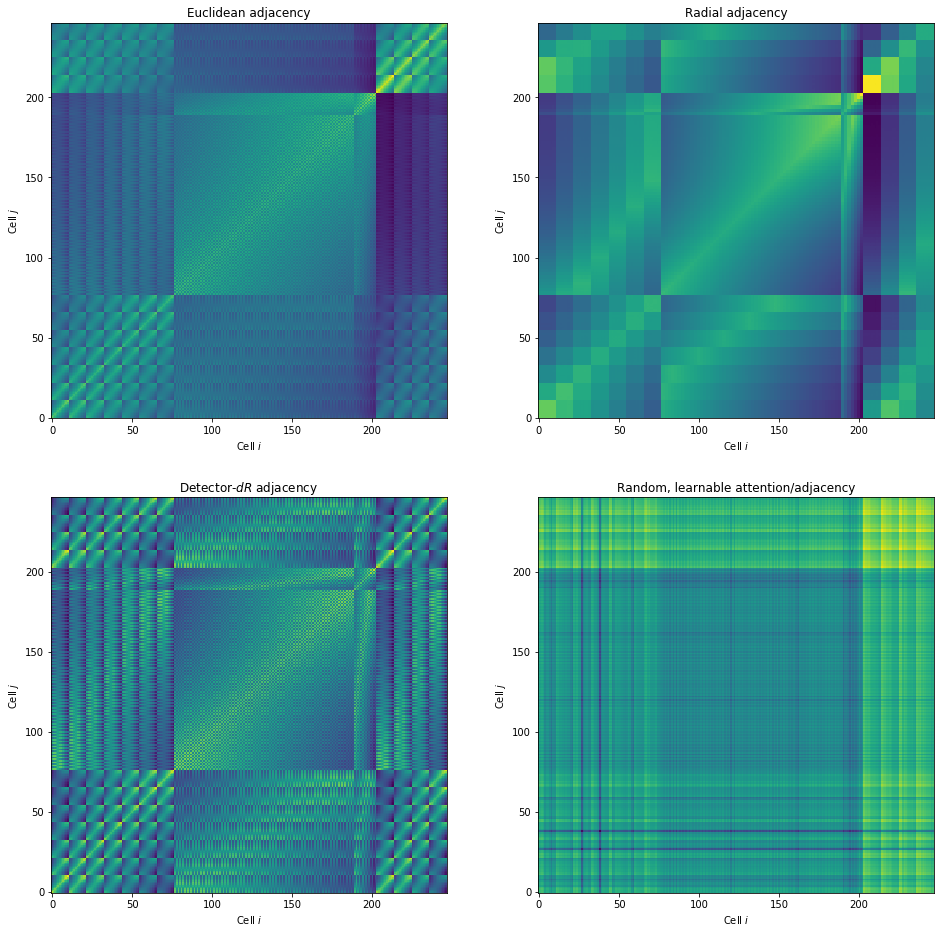

In [13]:
%matplotlib inline
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

ax[0,0].imshow(A, origin='se')
ax[0,0].set_title(r"Euclidean adjacency")
ax[0,0].set_xlabel(r"Cell $i$")
ax[0,0].set_ylabel(r"Cell $j$")

ax[1,0].imshow(B, origin='se')
ax[1,0].set_title(r"Detector-$dR$ adjacency")
ax[1,0].set_xlabel(r"Cell $i$")
ax[1,0].set_ylabel(r"Cell $j$")

ax[0,1].imshow(C, origin='se')
ax[0,1].set_title(r"Radial adjacency")
ax[0,1].set_xlabel(r"Cell $i$")
ax[0,1].set_ylabel(r"Cell $j$")

ax[1,1].imshow(D, origin='se')
ax[1,1].set_title(r"Random, learnable attention/adjacency")
ax[1,1].set_xlabel(r"Cell $i$")
ax[1,1].set_ylabel(r"Cell $j$")

plt.show()

Define GNN module

In [14]:
class NodeUpdate (torch.nn.Module):
    def __init__ (self, input_size, output_size, num_kernels, num_attention, activation):
        """NodeUpdate from 'Neural Message Passing for Jet Physics'."""
        super(NodeUpdate, self).__init__()
        
        # Check(s)
        # ...
    
        # Member variable(s)
        self._activation = activation
        self._softmax    = torch.nn.Softmax(dim=0)

        # -- Learnable attention/adjacency matrix parameters
        self._attention    = torch.nn.ParameterList([torch.nn.Parameter(torch.nn.init.xavier_uniform(torch.zeros(2 * input_size,  1)),      requires_grad=True) for _ in range(num_attention)])
        
        # -- Weight kernels and biases for fixed grid operators
        self._kernels_oprt = torch.nn.ParameterList([torch.nn.Parameter(torch.nn.init.xavier_uniform(torch.zeros(input_size, output_size)), requires_grad=True) for _ in range(num_kernels)])
        self._biases_oprt  = torch.nn.ParameterList([torch.nn.Parameter(torch.nn.init.xavier_uniform(torch.zeros(output_size, 1)),          requires_grad=True) for _ in range(num_kernels)])
        
        # -- Weight kernels and biases for learnable grid operators
        self._kernels_attn = torch.nn.ParameterList([torch.nn.Parameter(torch.nn.init.xavier_uniform(torch.zeros(input_size, output_size)), requires_grad=True) for _ in range(num_attention)])
        self._biases_attn  = torch.nn.ParameterList([torch.nn.Parameter(torch.nn.init.xavier_uniform(torch.zeros(output_size, 1)),          requires_grad=True) for _ in range(num_attention)])
        
        # -- Weights accumulating NodeUpdate terms
        self._term_weights = torch.nn.ParameterList([torch.nn.Parameter(torch.ones(num_kernels + num_attention, 1), requires_grad=True)])
        #self._term_weights = [Variable(torch.ones(num_kernels + num_attention, 1), requires_grad=False)]
        return
    
    def _apply (self, h, A, theta, bias):
        """
        Internal method to perform the matrix operations
        """
        return A.mm(h).mm(theta).view(A.shape[0], theta.shape[1], 1) + bias
                                                  
                                                  
    def forward (self, h, operators):
        assert len(operators) == len(self._kernels_oprt)
    
        # -----------
        # old
        #terms = [torch.mm(torch.mm(A, h), theta).view(A.shape[0], theta.shape[1], 1) + bias for (A, theta, bias) in zip(operators, self._kernels_oprt, self._biases_oprt)]
        #return torch.sum(torch.cat(terms, dim=2), dim=2)
        # -----------
        # new
        #"""
        attention = [learnable_adjacency_matrix(h,a) for a in self._attention]  # Learnable-adjacency matrices
        terms  = [self._apply(h, A, theta, bias) for (A, theta, bias) in zip(operators, self._kernels_oprt, self._biases_oprt)]                                    
        terms += [self._apply(h, A, theta, bias) for (A, theta, bias) in zip(attention, self._kernels_attn, self._biases_attn)]

        # Sum terms with learnable weights
        T = torch.cat(terms, dim=2)
        w = self._softmax(self._term_weights[0])
        return torch.sum(torch.matmul(T,w), dim=2)
        #"""
        # -----------
    pass
        
class GNN (torch.nn.Module):
    def __init__ (self, operators, architecture, num_attention=0):
        """Graph neural network."""
        super(GNN, self).__init__()

        # Check(s)
        assert isinstance(operators, list)
        assert isinstance(architecture, list)
        assert all(map(lambda e: isinstance(e, int), architecture))
        # ...
        
        # NOTE:
        # -----
        # We assume that e.g. `architecture = [16,10,10]` means that the input 
        # has 16 features, and that we should add a final, linear layer with 
        # dimensions `(16,1)` followed by sigmoid activation
        
        self._operators   = operators
        self._updates     = [NodeUpdate(dim_in, dim_out, len(self._operators), num_attention, torch.nn.Tanh()) for (dim_in, dim_out) in zip(architecture[:-1], architecture[1:])]
        self._classifier  = torch.nn.Linear(architecture[-1], 1)
       
        self._module_list = torch.nn.ModuleList(self._updates + [self._classifier])

        self._layers      = list()
        return
    
    def forward (self, h):
        
        # Perform successive NodeUpdates
        for iupdate, update in enumerate(self._updates):

            # Construct linear operators for current input dimensions
            operators = [operator(h) for operator in self._operators]

            # Perform NodeUpdate
            h = update.forward(h, operators)
            
            assert not np.any(np.isnan(h.data.numpy()) | np.isinf(h.data.numpy())), ("[{}]".format(iupdate), h)
            pass
        
        # Reduction to fixed size
        h = maxout(h)

        # Map to probability
        return torch.nn.Sigmoid()(self._classifier(h))
    pass

Trying out recurrent layers...

In [15]:
hidden_size = 7   # GRU output features
num_layers = 2     # GRU layers
input_size = 3
seq_len = 10
batch = 32

rnn = torch.nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
input = Variable(torch.randn(batch, seq_len, input_size))
h0 = Variable(torch.randn(batch, num_layers, hidden_size))
output, hn = rnn(input)#, h0)
#print output.shape, hn.shape

Construct GNN model

In [16]:
gnn = GNN([identity_matrix, euclidean_adjacency_matrix, dR_adjacency_matrix], [len(features),40,40], num_attention=3)
if CUDA:
    gnn.cuda()
    pass

Perform training

In [17]:
# Placeholders
h = Variable(torch.zeros(1,1))
y = Variable(torch.zeros(1,))
w = Variable(torch.zeros(1,))
dtype = torch.FloatTensor

# Loss
binary_crossentropy = torch.nn.BCELoss()

# Optimiser
optimiser = torch.optim.Adam(list(gnn.parameters()), lr=1e-05)

# Create validation set
validation = [next(generator) for _ in range(1000)]

# Event loop
batch_size = 1
mult = 1
stop = 20000
print "== Start ({})".format(data.size)
for step, (h_, y_, w_) in enumerate(generator):
    
    # Stop condition
    if stop and (step == stop):
        print "   Stopping at {}".format(step)
        break
    
    # Logging
    if step % mult == 0:
        print "== {}".format(step)
        if step == 10 * mult:
            mult *= 10
            pass
        pass
            
    # Fill placeholders
    h.data = h_
    y.data = y_
    w.data = w_
    
    # Get prediction, compute loss, perform back-propagation
    pred = gnn.forward(h)
    loss = torch.nn.BCELoss(w)(pred, y)
    loss.backward()
    
    # Print validation loss
    if step % len(validation) == 0:
        val_loss = 0.
        for h_, y_, w_ in validation:
            # Fill placeholders
            h.data = h_
            y.data = y_
            w.data = w_
            pred = gnn.forward(h)
            val_loss += torch.nn.BCELoss(w)(pred, y).data[0]
            pass
        val_loss /= len(validation)
        print "validation loss:", float(val_loss)
        pass

    # Draw diagram
    if step == 0:
        from torchviz import make_dot
        params = {str(i): param for (i,param) in enumerate(gnn.parameters())}
        params['input']  = h  # Not showing up...
        params['output'] = y  # Not showing up...
        dot = make_dot(loss, params=params)
        for fmt in ['png', 'pdf']:
            dot.format = fmt
            dot.render('output/model')
            pass
        pass
    
    # Update parameters
    if step > 0 and step % batch_size == 0:
        optimiser.step()
        optimiser.zero_grad()
        pass
    pass
print "== Done"

== Start (67797)
== 0
validation loss: 0.804112684641
== 1
== 2
== 3
== 4
== 5
== 6
== 7
== 8
== 9
== 10
== 20
== 30
== 40
== 50
== 60
== 70
== 80
== 90
== 100
== 200
== 300
== 400
== 500
== 600
== 700
== 800
== 900
== 1000
validation loss: 0.802855153965
== 2000
validation loss: 0.798434159603
== 3000
validation loss: 0.796173956646
== 4000
validation loss: 0.793990391445
== 5000
validation loss: 0.79137082928
== 6000
validation loss: 0.786724368703
== 7000
validation loss: 0.786171219887
== 8000
validation loss: 0.786460921937
== 9000
validation loss: 0.78580641337
== 10000
validation loss: 0.782475253726
validation loss: 0.782897810877
validation loss: 0.782530362153
validation loss: 0.783593458628
validation loss: 0.781627459633
validation loss: 0.784079104102
validation loss: 0.782437648122
validation loss: 0.786561017645
validation loss: 0.789576921063
validation loss: 0.788305506055
   Stopping at 20000
== Done


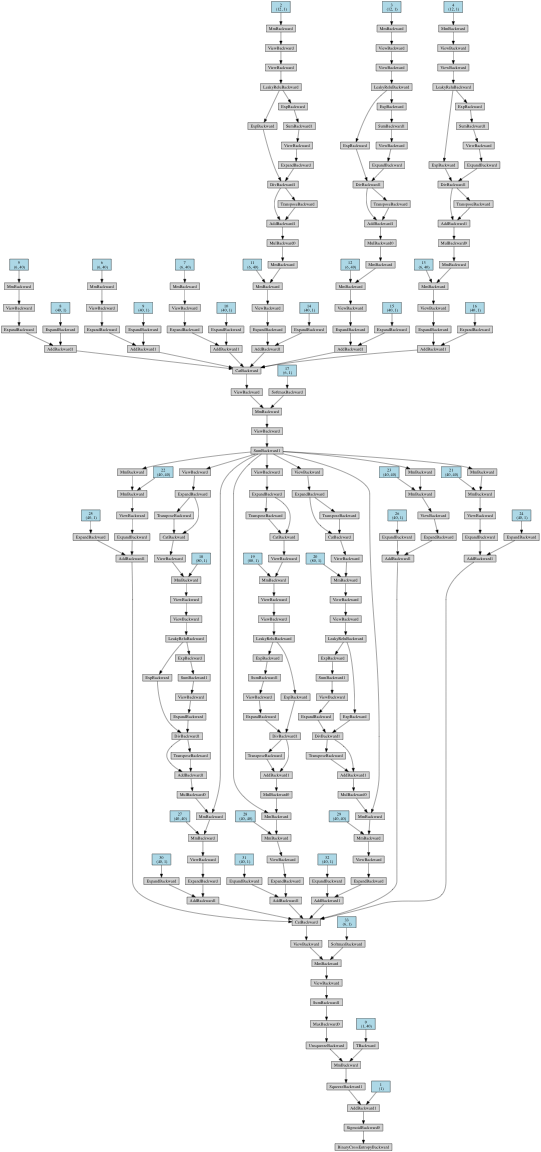

In [21]:
Image(filename='output/model.png')

Plot classifier distributions

In [25]:
# Create containers
preds  = list()
labels = list()
weight = list()

# Loop validation set
for step, (h_, y_, w_) in enumerate(generator):
    # Stop condition
    if step == 10000:
        break
        
    # Get predicting
    h.data = h_
    pred = gnn.forward(h)

    # Store results
    preds .append(float(pred.data.numpy()))
    labels.append(float(y_.numpy()))
    weight.append(float(w_.numpy()))
    pass
print "Done ({})".format(len(preds))

Done (10000)


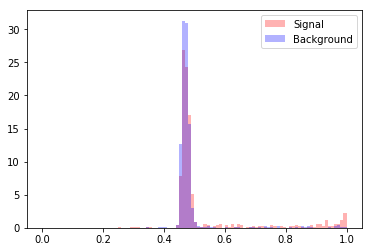

In [27]:
%matplotlib inline
bins = np.linspace(0, 1, 100 +  1, endpoint=True)
preds  = np.array(preds)
labels = np.array(labels)
weight = np.array(weight)
plt.hist(preds[labels == 1], bins=bins, weights=weight[labels == 1], color='red',  normed=True, alpha=0.3, label='Signal')
plt.hist(preds[labels == 0], bins=bins, weights=weight[labels == 0], color='blue', normed=True, alpha=0.3, label='Background')
plt.legend()
plt.show()